#  Projeção do IPCA com Machine Learning (XGBoost + Features Macroeconômicas)

##  Autor
**Rafael Eiki Teruya** - Aluno de Economia da FEA-USP 

##  Objetivo
Construir um modelo preditivo para o **IPCA mensal** utilizando técnicas de **Machine Learning** (XGBoost), com base em variáveis macroeconômicas, financeiras e de commodities.

##  Fontes de Dados
- **Banco Central do Brasil (SGS)** → séries de inflação, PIB, juros, câmbio, índices de preços.  
- **FRED (Federal Reserve Bank of St. Louis)** → séries internacionais de commodities (petróleo, soja, milho, café etc.).


##  Metodologia
1. **Coleta e tratamento de dados** de diferentes fontes.  
2. **Engenharia de features**: lags, variações percentuais, volatilidades, interações econômicas.  
3. **Pré-processamento**: normalização com `StandardScaler` e divisão em treino/teste.  
4. **Otimização de hiperparâmetros** com **Optuna**.  
5. **Treinamento do modelo XGBoost**.  
6. **Avaliação do desempenho** utilizando as seguintes métricas:  
   - **RMSE** (Root Mean Squared Error)  
   - **MAE** (Mean Absolute Error)  
   - **R²** (Coeficiente de determinação)  
7. **Visualização dos resultados**: comparação de previsões vs valores reais.

---


# Carregando Bibliotecas

In [ ]:
# importando as bibliotecas
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from bcb import sgs
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
from bcb import sgs
import pandas as pd
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Coleta de Séries Econômicas do SGS (Banco Central)

Neste trecho vamos baixar algumas séries macroeconômicas brasileiras diretamente do **SGS (Sistema Gerenciador de Séries Temporais)** do Banco Central do Brasil, utilizando o pacote `bcb`.

- As séries escolhidas incluem índices de preços (IPCA, IPA-DI, IGP-M, INCC, INPC), medidas de inflação (IPCA cheio, IPCA núcleo, acumulado em 12 meses, administrados) e atividade econômica (PIB mensal / IBC-Br).  
- O período inicial definido foi **janeiro de 1992**, garantindo um histórico extenso para análise.  
- A função `sgs.get()` retorna um `DataFrame` com:
  - **Índice temporal** (datas mensais)
  - **Colunas nomeadas** conforme o dicionário de códigos selecionados  

Este dataset servirá como base para a previsão do IPCA.


In [ ]:
# Baixando os dados mensais
codigos_selecionados = {
    "IPCA": 433,
    "IPCA_EX1": 16121,
    "IPCA_acumulado_12_meses": 13522,
    "IPCA_administrados": 4449,
    "IPA-DI": 225,
    "IGP-M": 189,
    "INCC": 192,
    "INPC": 188,
    "PIB_mensal": 4380
}

# Baixando os dados mensais
dados_sgs_mensal = sgs.get(codigos_selecionados, start='1992-01-01')
dados_sgs_mensal

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal
Date,,,,,,,,,
1992-01-01,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1
1992-02-01,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3
1992-03-01,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6
1992-04-01,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6
1992-05-01,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1
...,...,...,...,...,...,...,...,...,...
2025-04-01,0.43,0.47,5.53,0.35,0.20,0.24,0.52,0.48,1080004.8
2025-05-01,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7
2025-06-01,0.24,0.42,5.35,0.60,-2.72,-1.67,0.69,0.23,1041629.6


# Coleta de Séries Diárias (SELIC, Câmbio e CDI)

Além das séries mensais, também vamos buscar séries financeiras que estão disponíveis em **frequência diária** no SGS:  
- **SELIC (código 11)**  
- **Câmbio (código 1, R$/US$)**  
- **CDI (código 12)**  

Com isso, temos um **painel unificado** de indicadores macroeconômicos e financeiros em base **mensal**, pronto para análise e modelagem.


In [ ]:
# dicionário com as séries diárias
series_diarias = {
    "SELIC":11,
    "Cambio":1,
    "CDI":12
}

# Baixando os dados diários em blocos de 10 anos para evitar limites da API
anos = [1992,2002,2012,2022]
dados_sgs_diários = pd.DataFrame()
for ano in anos:
    dados_diarios = sgs.get(series_diarias, start=f'{ano}-01-01', end=f'{ano+9}-12-31')
    dados_sgs_diários = pd.concat([dados_sgs_diários, dados_diarios], axis=0)

# Convertendo a frequência de diária para mensal
dados_sgs_diários = dados_sgs_diários.resample('M').first()
dados_sgs_mensal = dados_sgs_mensal.resample('M').first()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_10288\4291305547.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dados_sgs_diários = dados_sgs_diários.resample('M').first()
C:\Users\Rafael\AppData\Local\Temp\ipykernel_10288\4291305547.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dados_sgs_mensal = dados_sgs_mensal.resample('M').first()


In [ ]:
# unindo os dois dataframes
df_sgs = dados_sgs_mensal.merge(dados_sgs_diários, left_index=True, right_index=True, how="outer")
df_sgs

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,Cambio,CDI
Date,,,,,,,,,,,,
1992-01-31,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1,1.171667,1079.4000,1.162000
1992-02-29,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3,1.262000,1333.2500,1.266333
1992-03-31,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6,1.252333,1647.5500,1.249333
1992-04-30,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6,1.176000,2007.1000,1.173333
1992-05-31,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1,1.065667,2417.0000,1.065333
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7,0.052531,5.6394,0.052531
2025-06-30,0.24,0.42,5.35,0.60,-2.72,-1.67,0.69,0.23,1041629.6,0.054266,5.6937,0.054266
2025-07-31,0.26,0.50,5.23,0.67,-0.34,-0.77,0.91,0.21,1078347.6,0.055131,5.4511,0.055131


# Hiato do Produto (HP Filter)

Nesta etapa calculamos o **hiato do produto** usando o PIB mensal (IBC-Br) como proxy da atividade econômica.  

- Aplicamos logaritmo na série para suavizar e interpretar em termos percentuais.  
- Separamos tendência e ciclo com o filtro de Hodrick-Prescott (`hpfilter`, λ = 129600 para dados mensais).  
- Definimos o hiato como o desvio percentual do PIB em relação à sua tendência:  
  $
  \text{Hiato} = \frac{PIB - PIB_{tend}}{PIB_{tend}} \times 100
  $

Valores positivos indicam economia **acima do potencial**, negativos indicam **ociosidade**.


In [ ]:
# Calculando o hiato do PIB
pib = np.log(df_sgs["PIB_mensal"].dropna())
pib_ciclo, pib_tend = hpfilter(pib, lamb=129600)
df_sgs["PIB_hiato"] = (pib - pib_tend)/pib_tend*100
df_sgs

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,Cambio,CDI,PIB_hiato
Date,,,,,,,,,,,,,
1992-01-31,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1,1.171667,1079.4000,1.162000,-35.905555
1992-02-29,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3,1.262000,1333.2500,1.266333,-33.294695
1992-03-31,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6,1.252333,1647.5500,1.249333,-31.673209
1992-04-30,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6,1.176000,2007.1000,1.173333,-30.143526
1992-05-31,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1,1.065667,2417.0000,1.065333,-27.498117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7,0.052531,5.6394,0.052531,-0.057783
2025-06-30,0.24,0.42,5.35,0.60,-2.72,-1.67,0.69,0.23,1041629.6,0.054266,5.6937,0.054266,-0.205574
2025-07-31,0.26,0.50,5.23,0.67,-0.34,-0.77,0.91,0.21,1078347.6,0.055131,5.4511,0.055131,-0.011269


# Base de Commodities (FRED - St. Louis Fed)

Nesta etapa, carregamos cotações internacionais de commodities baixadas do **FRED (Federal Reserve Economic Data, St. Louis Fed)**.  
As séries utilizadas incluem:  
- Petróleo Brent (POILBREUSDM)  
- Soja (PSOYBUSDM)  
- Milho (PMAIZMTUSDM)  
- Carne bovina (PBEEFUSDM)  
- Café arábica (PCOFFOTMUSDM) 


In [ ]:
# Extrair os dados coletados pelo FRED
df_petroleo = pd.read_csv("Downloads/POILBREUSDM(1).csv")
df_soja = pd.read_csv("Downloads/PSOYBUSDM(1).csv")
df_milho = pd.read_csv("Downloads/PMAIZMTUSDM(1).csv")
df_carne = pd.read_csv("Downloads/PBEEFUSDM(2).csv")
df_cafe_arab = pd.read_csv("Downloads/PCOFFOTMUSDM(1).csv")

# Concatenar todos os DataFrames em um único DataFrame
df_commodities = pd.concat([df_petroleo, df_soja, df_milho, df_cafe_arab], axis=0, ignore_index=True)
df_commodities['observation_date'] = pd.to_datetime(df_commodities['observation_date'])
df_commodities.set_index(df_commodities['observation_date'], inplace=True)
df_commodities.drop('observation_date', axis=1, inplace=True)

# Convertendo a frequência diária para mensal
df_commodities=df_commodities.resample("M").mean().dropna(axis=0)
df_commodities=df_commodities.resample("M").last()
df_commodities

C:\Users\Rafael\AppData\Local\Temp\ipykernel_10288\3224151318.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_commodities=df_commodities.resample("M").mean().dropna(axis=0)
C:\Users\Rafael\AppData\Local\Temp\ipykernel_10288\3224151318.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_commodities=df_commodities.resample("M").last()


,POILBREUSDM,PSOYBUSDM,PMAIZMTUSDM,PCOFFOTMUSDM
observation_date,,,,
1992-01-31,18.156522,208.610226,109.586357,73.031818
1992-02-29,18.110000,211.159575,113.921257,69.298000
1992-03-31,17.659091,216.143437,116.684593,69.893636
1992-04-30,19.015909,211.297378,109.055138,66.522273
1992-05-31,19.980952,220.369384,109.177910,60.796667
...,...,...,...,...
2025-02-28,75.193000,382.083957,221.254544,409.516500
2025-03-31,71.741429,369.344173,207.751691,404.210476
2025-04-30,66.927273,378.066199,215.569093,392.912727


In [ ]:
# unindo os dois dataframes
df = pd.concat([df_sgs, df_commodities], axis=1).dropna(axis=0)
df

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,Cambio,CDI,PIB_hiato,POILBREUSDM,PSOYBUSDM,PMAIZMTUSDM,PCOFFOTMUSDM
1992-01-31,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1,1.171667,1079.4000,1.162000,-35.905555,18.156522,208.610226,109.586357,73.031818
1992-02-29,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3,1.262000,1333.2500,1.266333,-33.294695,18.110000,211.159575,113.921257,69.298000
1992-03-31,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6,1.252333,1647.5500,1.249333,-31.673209,17.659091,216.143437,116.684593,69.893636
1992-04-30,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6,1.176000,2007.1000,1.173333,-30.143526,19.015909,211.297378,109.055138,66.522273
1992-05-31,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1,1.065667,2417.0000,1.065333,-27.498117,19.980952,220.369384,109.177910,60.796667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,1.31,1.33,5.06,3.16,1.03,1.06,0.40,1.48,992799.2,0.049037,5.8687,0.049037,-0.331225,75.193000,382.083957,221.254544,409.516500
2025-03-31,0.56,0.50,5.48,0.18,-0.88,-0.34,0.39,0.51,1065766.2,0.049037,5.7914,0.049037,0.125262,71.741429,369.344173,207.751691,404.210476
2025-04-30,0.43,0.47,5.53,0.35,0.20,0.24,0.52,0.48,1080004.8,0.052531,5.7051,0.052531,0.165598,66.927273,378.066199,215.569093,392.912727
2025-05-31,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7,0.052531,5.6394,0.052531,-0.057783,64.092727,387.649984,204.808448,397.588636


# Removendo Look-Ahead Bias com Lags

Neste trecho, aplicamos um **lag de 1 mês** em todas as variáveis explicativas, exceto `IPCA`.  

### Conceito-chave:
- **Look-ahead bias** ocorre quando o modelo tem acesso a informações que só seriam conhecidas **no futuro**, gerando previsões irrealisticamente boas.  
- Ao aplicar o lag, **removemos esse viés**, garantindo que cada feature represente apenas dados que estariam realmente disponíveis no período de previsão.

In [ ]:
# Aplicando o shift de 1 mês em todas as colunas exceto IPCA
colunas_shift = df.columns[df.columns != "IPCA"]
df[colunas_shift] = df[colunas_shift].shift(1)
df.dropna(axis=0, inplace=True)

# Função para Criar Múltiplos Lags

A função `criar_lags` gera **variáveis defasadas** de um DataFrame, permitindo criar lags múltiplos de todas as colunas de forma automatizada.  

### Parâmetros:
- `dados`: DataFrame com as variáveis originais.  
- `nlags`: lista com os números de períodos para os quais se deseja criar lags (ex.: `[1,2,3]`).

In [36]:
def criar_lags(dados, nlags=None):
    df_lags = pd.DataFrame()
    for lag in nlags:
        for i in range(dados.shape[1]):
            df_lags[f"{dados.columns[i]}_lag{lag}"] = dados[dados.columns[i]].shift(lag)
    return df_lags

# Criação de Features Derivadas

Neste bloco, geramos features adicionais para a modelagem do IPCA:  
- **Volatilidade 3 meses** do IPCA (`Vol_3m`).  
- **Variações percentuais mensais** (`IPCA_var1m_%`, `IGP-M_var1m_%`, `PIB_mensal_var1m_%`).  
- **Lags múltiplos** de IPCA, IPA-DI, Câmbio e PIB, para capturar efeitos passados.  
- **Interações econômicas**, como `Cambio x Petróleo` e `Hiato x Juros`.  
- Consolidamos todas as features em um DataFrame final, removendo `NaN` e infinitos.


In [ ]:
# Criando novas features
df['Vol_3m'] = (df['IPCA']/100).rolling(3).std().astype('float')

# Variação percentual de 1 mês
df['IPCA_var1m_%'] = df['IPCA'].pct_change(1).astype('float')
df['IGP-M_var1m_%'] = df['IGP-M'].pct_change(1).astype('float')
df['PIB_mensal_var1m_%'] = df['PIB_mensal'].pct_change(1).astype('float')

# Criando lags específicos para algumas variáveis
df_lags_ipca = criar_lags(df[["IPCA"]], nlags=[1,3,12])
df_lags_ipa_di = criar_lags(df[["IPA-DI"]], nlags=[1,3])
df_lags_cambio = criar_lags(df[["Cambio"]], nlags=[2])
df_lags_pib = criar_lags(df[["PIB_mensal"]], nlags=[1,2,3])

# Criando interações entre variáveis
df['Cambio_x_Petroleo'] = df['Cambio'] * df['POILBREUSDM']
df['Hiato_x_Juros'] = df['PIB_hiato'] * (1+df['SELIC'])**(1/12)-1

# unindo todos os dataframes
df = pd.concat([df, df_lags_ipca, df_lags_ipa_di, df_lags_cambio, df_lags_pib], axis=1).dropna(axis=0)
df = df.replace([-np.inf, np.inf], 0)
df

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,...,Hiato_x_Juros,IPCA_lag1,IPCA_lag3,IPCA_lag12,IPA-DI_lag1,IPA-DI_lag3,Cambio_lag2,PIB_mensal_lag1,PIB_mensal_lag2,PIB_mensal_lag3
1993-02-28,24.98,30.22,1161.79,32.93,26.69,25.83,36.90,28.77,164.0,1.201333,...,-17.767324,30.35,22.49,24.32,23.78,24.83,8123.0000,127.7,110.4,89.0
1993-03-31,27.26,24.77,1168.49,29.24,26.23,28.41,22.60,24.79,206.9,1.425333,...,-16.313838,24.98,25.24,21.40,26.69,24.43,10046.2000,164.0,127.7,110.4
1993-04-30,27.75,27.42,1229.71,24.51,28.08,26.25,32.61,27.58,294.6,1.201667,...,-12.658429,27.26,30.35,19.93,26.23,23.78,12531.5000,206.9,164.0,127.7
1993-05-31,27.69,27.04,1316.42,29.15,28.32,28.83,21.28,28.37,368.1,1.385000,...,-11.490249,27.75,24.98,24.86,28.08,26.69,15931.2500,294.6,206.9,164.0
1993-06-30,30.07,27.71,1348.52,29.48,32.06,29.70,40.60,26.78,481.6,1.312000,...,-9.528833,27.69,27.26,20.21,28.32,26.23,20062.0000,368.1,294.6,206.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,1.31,0.02,4.56,-1.52,0.03,0.27,0.83,0.00,961013.5,0.045513,...,-1.512917,0.16,0.39,0.83,1.08,2.01,5.8073,1006123.7,1026206.9,1048036.9
2025-03-31,0.56,1.33,5.06,3.16,1.03,1.06,0.40,1.48,992799.2,0.049037,...,-1.332549,1.31,0.52,0.16,0.03,1.66,6.0634,961013.5,1006123.7,1026206.9
2025-04-30,0.43,0.50,5.48,0.18,-0.88,-0.34,0.39,0.51,1065766.2,0.049037,...,-0.874238,0.56,0.16,0.38,1.03,1.08,6.2086,992799.2,961013.5,1006123.7
2025-05-31,0.26,0.47,5.53,0.35,0.20,0.24,0.52,0.48,1080004.8,0.052531,...,-0.833694,0.43,1.31,0.46,-0.88,0.03,5.8687,1065766.2,992799.2,961013.5


# Padronização e Divisão Treino/Teste

Neste bloco preparamos os dados para modelagem do IPCA:

- Separamos **X** (features) e **y** (target: IPCA).  
- Aplicamos **StandardScaler** para padronizar médias e desvios das variáveis.  
- Dividimos os dados em **treino (80%)** e **teste (20%)**, mantendo a ordem temporal para preservar consistência na previsão.


In [ ]:
# Dividindo em variável dependente e independentes
X = df.drop('IPCA', axis=1).astype('float')
y = df['IPCA'].astype('float')

# Normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Dividindo em treino e teste (80% treino, 20% teste)
X_train, y_train = X_scaled[:int(0.8*(len(X)))], y_scaled[:int(0.8*(len(X)))]
X_test, y_test = X_scaled[int(0.8*(len(X))):], y_scaled[int(0.8*(len(X))):]

# Função Objetivo para Otimização com Optuna

Nesta função definimos como o Optuna irá **procurar os melhores hiperparâmetros** para o XGBoost na previsão do IPCA.

### Detalhes:

1. **Espaços de busca dos hiperparâmetros**  
   - `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`, `min_child_weight`, `gamma`, `max_delta_step`  

2. **Modelo**  
   - `XGBRegressor` com os parâmetros sugeridos pelo trial do Optuna.

3. **Validação cruzada**  
   - `KFold(n_splits=7, shuffle=False)` para respeitar a ordem temporal da série.  
   - `cross_val_score` avalia o modelo usando **MSE negativo** como métrica.

4. **Retorno**  
   - A função retorna a média do score negativo do MSE para que o Optuna **minimize o erro**.

> Observação: o uso de `shuffle=False` garante que a validação respeite a sequência temporal, evitando look-ahead bias.


In [140]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.26),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42
    }

    # Modelo
    model = XGBRegressor(**params)

    # Validação cruzada (ajuste se for série temporal!)
    cv = KFold(n_splits=7, shuffle=False)

    # Minimizar MSE
    score = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring="neg_mean_squared_error",
                            n_jobs=-1)
    
    return np.mean(score)


# Função de Busca de Hiperparâmetros com Optuna

A função `search` realiza múltiplas execuções do processo de otimização para identificar os **melhores hiperparâmetros do XGBoost**.  

### Detalhes:

1. **Iterações externas** (`iterações`)  
   - Permite repetir o estudo várias vezes para reduzir variações devido à aleatoriedade da otimização.

2. **Criação do estudo Optuna**  
   - `optuna.create_study(direction="maximize")` cria um estudo para maximizar a função objetivo (negativo do MSE).

3. **Otimização interna**  
   - `study.optimize(objective, n_trials=100, n_jobs=-1)` executa 100 trials paralelos para explorar o espaço de hiperparâmetros definido na função `objective`.

4. **Registro dos resultados**  
   - `melhor_resultado`: lista com os melhores scores de cada iteração.  
   - `melhor_param`: lista com os melhores parâmetros correspondentes.  
   - Ordena os resultados para sempre identificar o **melhor score absoluto**.

5. **Retorno**  
   - Retorna o **menor MSE absoluto** encontrado e os **hiperparâmetros correspondentes**.

> Observação: Repetir múltiplas iterações ajuda a reduzir o risco de escolher um ótimo local ruim devido à aleatoriedade do algoritmo de otimização.


In [145]:
def search(iterações):
    # Criar listas vazias
    melhor_resultado = []
    melhor_param = []

    # Loop de iterações
    i = 0
    while i < iterações:
        i += 1

        # Criar estudo e otimizar
        study = optuna.create_study(direction="maximize")  
        study.optimize(objective, n_trials=200, n_jobs=-1)

        # Registrando os melhores resultados
        melhor_resultado.append((np.abs(study.best_value)))
        melhor_param.append((study.best_params))

        # Ordenando e exibindo o melhor resultado até agora
        melhor_resultado.sort()
        print(f"Iteração {i}/{iterações} concluída. Melhor resultado até agora: {melhor_resultado[0]}")

    return melhor_resultado[0], melhor_param[melhor_resultado.index(melhor_resultado[0])]

In [146]:
# Executando a busca por hiperparâmetros
_, melhores_param = search(iterações=10)

Iteração 1/10 concluída. Melhor resultado até agora: 1.1401748760361599
Iteração 2/10 concluída. Melhor resultado até agora: 1.1274522445321922
Iteração 3/10 concluída. Melhor resultado até agora: 1.1274522445321922
Iteração 4/10 concluída. Melhor resultado até agora: 1.1274522445321922
Iteração 5/10 concluída. Melhor resultado até agora: 1.127014871224827
Iteração 6/10 concluída. Melhor resultado até agora: 1.127014871224827
Iteração 7/10 concluída. Melhor resultado até agora: 1.127014871224827
Iteração 8/10 concluída. Melhor resultado até agora: 1.127014871224827
Iteração 9/10 concluída. Melhor resultado até agora: 1.127014871224827
Iteração 10/10 concluída. Melhor resultado até agora: 1.127014871224827


In [147]:
# Melhores parâmetros encontrados
melhores_param

{'n_estimators': 172,
 'max_depth': 5,
 'learning_rate': 0.23417195890163964,
 'subsample': 0.793712579742473,
 'colsample_bytree': 0.9228073450181835,
 'reg_alpha': 0.015784423400589775,
 'reg_lambda': 1.9702453163546463,
 'min_child_weight': 4}

# Avaliação do Modelo Otimizado

Após selecionar os melhores hiperparâmetros via Optuna, treinamos o **XGBoost** com os dados de treino e avaliamos seu desempenho nos dados de teste.

### Passos:
1. Treinamento do modelo com os hiperparâmetros ótimos.  
2. Geração das previsões (`y_chapeu`) no conjunto de teste.  
3. Inversão da padronização (`StandardScaler`) para retornar os valores ao nível original do IPCA.  
4. Cálculo das principais métricas de avaliação:
   - **RMSE** (Root Mean Squared Error): erro quadrático médio.  
   - **MAE** (Mean Absolute Error): erro absoluto médio.  
   - **R²** (Coeficiente de determinação): proporção da variância explicada.  

Os resultados são organizados em um DataFrame (`df_metricas`) para fácil interpretação.


In [148]:
# Criando e treinando o modelo
modelo = XGBRegressor(**melhores_param, random_state=42)
modelo.fit(X_train, y_train)

# Previsões
y_chapeu = modelo.predict(X_test)
y_chapeu = scaler.inverse_transform(y_chapeu.reshape(-1,1))

# Valores reais sem a normalização
y = scaler.inverse_transform(y_test.reshape(-1,1))

# df de métricas 
df_metricas = pd.DataFrame({
    "RMSE": [root_mean_squared_error(y, y_chapeu)],
    "MAE": [mean_absolute_error(y, y_chapeu)],
    "R2": [r2_score(y, y_chapeu)],
})

df_metricas.index = ["Métricas"]
df_metricas

,RMSE,MAE,R2
Métricas,0.226449,0.163042,0.708498


# Avaliação Final do Modelo – Interpretação Detalhada

A tabela apresenta as métricas de desempenho do modelo XGBoost no conjunto de teste:

| Métrica | Valor |
|---------|-------|
| RMSE    | 0.226 |
| MAE     | 0.163 |
| R²      | 0.708 |

### Interpretação:

1. **RMSE (Root Mean Squared Error = 0.226)**  
   - Indica o **erro médio quadrático** das previsões do IPCA.  
   - Valores mais baixos significam que o modelo raramente comete grandes erros.  
   - No contexto do IPCA, um RMSE de 0.226 pontos percentuais mensais é **relativamente baixo**, sugerindo que o modelo consegue capturar bem os movimentos da inflação.

2. **MAE (Mean Absolute Error = 0.163)**  
   - Mede o **erro absoluto médio** das previsões.  
   - Diferente do RMSE, não penaliza fortemente grandes desvios, portanto dá uma visão do erro “típico” do modelo.  
   - Um MAE de 0.163 indica que, em média, as previsões diferem do IPCA real por aproximadamente 0.16 pontos percentuais, o que é **aceitável para previsões mensais de inflação**.

3. **R² (Coeficiente de determinação = 0.708)**  
   - Indica a **proporção da variância do IPCA explicada pelo modelo**.  
   - R² de 0.71 significa que o modelo consegue explicar **71% das variações da inflação mensal**, deixando 29% da variabilidade sem captura.  
   - Isso sugere que, embora o modelo seja eficiente, há **fatores macroeconômicos ou choques exógenos** não contemplados nas features que influenciam o IPCA.

### Conclusão:
- O modelo XGBoost apresenta **bom desempenho** e captura grande parte da dinâmica do IPCA.  
- Pequenas diferenças entre previsões e valores reais são esperadas, especialmente em meses com **choques inesperados** na economia (ex.: alterações bruscas de preços administrados, câmbio ou commodities).  
- As métricas sugerem que o modelo é **adequado para previsão de curto a médio prazo** 


# Gráfico de Previsões vs Valores Reais

Este gráfico compara o **IPCA observado** com as **previsões do modelo XGBoost** no conjunto de teste.

- Linha **Real**: valores históricos do IPCA.  
- Linha **Previsões XGBoost**: valores estimados pelo modelo.  
- O objetivo é avaliar visualmente a **qualidade do ajuste**, identificar períodos de boa aderência e eventuais desvios sistemáticos.


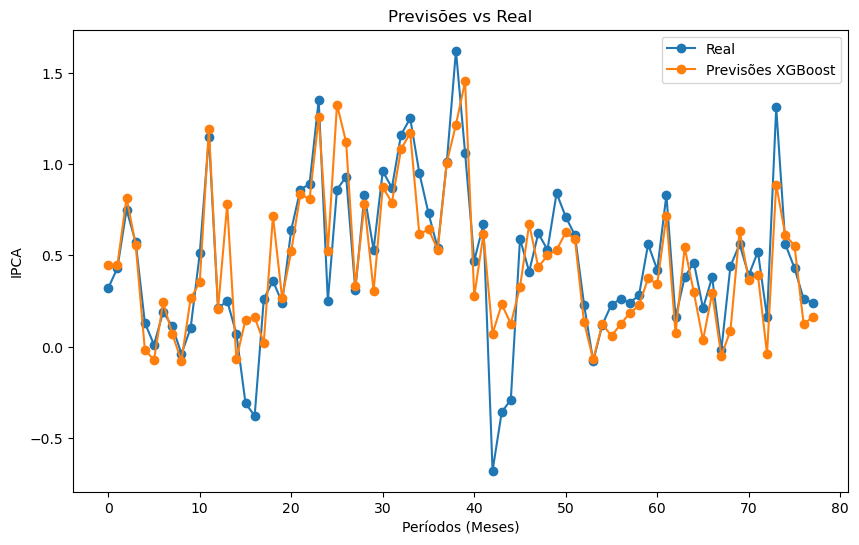

In [151]:
# Gráfico previsões vs real
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.plot(y, label='Real', marker='o')
plt.plot(y_chapeu, label='Previsões XGBoost', marker='o')
plt.title('Previsões vs Real')
plt.xlabel('Períodos (Meses)')
plt.ylabel('IPCA')
plt.legend()
plt.show()

### Observações:
1. O modelo consegue **acompanhar bem os movimentos gerais do IPCA**, capturando períodos de alta e baixa.  
2. Pequenos desvios acontecem em meses com **choques econômicos inesperados**.  
3. A aderência visual confirma as métricas calculadas anteriormente (**RMSE = 0.226, MAE = 0.163, R² = 0.71**), mostrando que o modelo tem **boa capacidade preditiva**, mesmo sem capturar 100% das flutuações pontuais.  


# Conclusão

O modelo XGBoost mostrou-se bastante eficaz para a previsão do **IPCA mensal**, com resultados quantitativos e qualitativos consistentes:

- **RMSE = 0.226**, **MAE = 0.163** → erros de previsão relativamente baixos, indicando boa precisão.  
- **R² = 0.71** → o modelo explica aproximadamente **71% da variabilidade** do IPCA no período de teste.  
- O gráfico de previsões vs valores reais confirma que o modelo **acompanha bem a dinâmica inflacionária**, embora apresente pequenas divergências em pontos de choque econômico.  

### Pontos fortes:
- Boa captura das **tendências e ciclos inflacionários**.  
- Robustez mesmo com um conjunto limitado de observações (~300).  
- Redução de viés de antecipação (lookahead bias) ao aplicar defasagens nas variáveis explicativas.  

### Limitações e próximos passos:
- O modelo ainda tem dificuldade em prever **picos inesperados** do IPCA, muitas vezes associados a choques externos (commodities, câmbio, política de preços administrados).  
- Pode ser aprimorado com:
  - Inclusão de **mais lags das variáveis explicativas**.  
  - Testes com **modelos híbridos** (ML + ARIMA/VAR).  
  - Validação **walk-forward**.  

**Em resumo:** o XGBoost é uma ferramenta poderosa para previsão de inflação, capturando a maior parte da variação do IPCA, e serve como base sólida para análises econômicas mais avançadas.
